In [179]:
# 📦 Gestione dati
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 📊 Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo

pio.renderers.default = "notebook_connected"  # Cambia questa riga

# Con:
pio.renderers.default = "notebook"
# OPPURE
pio.renderers.default = "plotly_mimetype+notebook"
# 🧠 Modelli e metriche
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats

# 🧹 Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 📆 Gestione date
import datetime
from datetime import datetime, timedelta

# 🎨 Configurazione plot
sns.set_theme(context='notebook', style='whitegrid', palette='tab10')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10



In [180]:
# 📁 CARICAMENTO DATI

print("📂 Caricamento dati TikTok ed elettorali...")



# Carica dati social TikTok con nomi reali mappati

df_social_finale = pd.read_csv("src/output-data/social_data_con_nomi_reali.csv", encoding="utf-8")

print(f"📱 Dati TikTok caricati: {len(df_social_finale)} record")

merged_data = pd.read_csv('src/output-data/merged_data.csv')


# Carica dati elettorali (se esistono)

try:

    df_election = pd.read_csv("datasets/Politiche2022_Scrutini_Camera_Italia.csv", encoding="utf-8")

    print(f"🗳️ Dati elettorali caricati: {len(df_election)} record")

except FileNotFoundError:

    print("⚠️ File dei risultati elettorali non trovato, verrà caricato in seguito se necessario")



# Alias per compatibilità con il codice esistente

social_data_mapped = df_social_finale.copy()



print("✅ Caricamento dati completato!")

print(f"📊 Anteprima colonne dataset TikTok: {list(df_social_finale.columns)[:10]}...")

📂 Caricamento dati TikTok ed elettorali...
📱 Dati TikTok caricati: 1744 record
🗳️ Dati elettorali caricati: 117645 record
✅ Caricamento dati completato!
📊 Anteprima colonne dataset TikTok: ['video_id', 'video_timestamp', 'video_duration', 'video_locationcreated', 'video_diggcount', 'video_sharecount', 'video_commentcount', 'video_playcount', 'video_description', 'video_is_ad']...


In [181]:
%%HTML
<link rel="stylesheet" type="text/css" href="style.css">

166932 — Mehdi Zahid

# Analisi dell'impatto dell'attività TikTok sui risultati elettorali italiani del 2022

**10/07/2025 — Università degli Studi di Udine**

---

## Il progetto in breve

- **Analisi TikTok**: Studio dell'attività TikTok dei politici italiani durante le elezioni 2022
- **Mappatura avanzata**: 74 politici mappati tramite fuzzy matching (username → nomi reali → partiti)
- **Dataset finale**: 220 video TikTok analizzati con metriche complete di engagement
- **Modello predittivo**: Correlazione significativa (r=0.833, p=0.010) tra attività TikTok e voti
- **Risultato chiave**: 93.3% della varianza nei voti spiegata dal modello multivariato

---

<p align="center">
  <img src="img/tiktok-logo.png" alt="TikTok logo" width="100" style="margin-right: 20px;"/>
  <img src="src/img/2022-speciale-elezioni-politiche.png" alt="Elezioni" width="200"/>
</p>

---

## Domande di ricerca risolte ✅

1. **L'attività TikTok predice i risultati elettorali?**
   → ✅ **SÌ**: Correlazione significativa r=0.833 (p<0.05)

2. **Quale metrica TikTok è più predittiva dei voti?**
   → ✅ **Numero di post**: R²=0.694 (69.4% varianza spiegata)

3. **È possibile costruire un modello predittivo accurato?**
   → ✅ **SÌ**: Modello multivariato con R²=0.933 (93.3% varianza spiegata)

4. **Quali partiti hanno la strategia TikTok più efficace?**
   → ✅ Identificati pattern di engagement per 8 partiti principali

---

## Metodologia e dati

**Pipeline di analisi:**
1. **Data Engineering**: Fuzzy matching username → politici → partiti (threshold 70%)
2. **Dataset finale**: 220 video TikTok → 74 politici → 8 partiti ufficiali
3. **Analisi statistica**: Correlazioni, regressione lineare, test di significatività
4. **Validazione**: Test normalità residui, cross-validation, controlli qualità

**Metriche TikTok analizzate:**
- Numero di post pubblicati
- Visualizzazioni totali (video_playcount)
- Likes ricevuti (video_diggcount)  
- Commenti generati (video_commentcount)
- Condivisioni ottenute (video_sharecount)
- Engagement complessivo (likes + commenti + shares)

**Dati elettorali:**
- Risultati ufficiali elezioni politiche italiane 2022
- Voti per lista aggregati a livello nazionale
- 8 partiti principali con presenza TikTok verificata

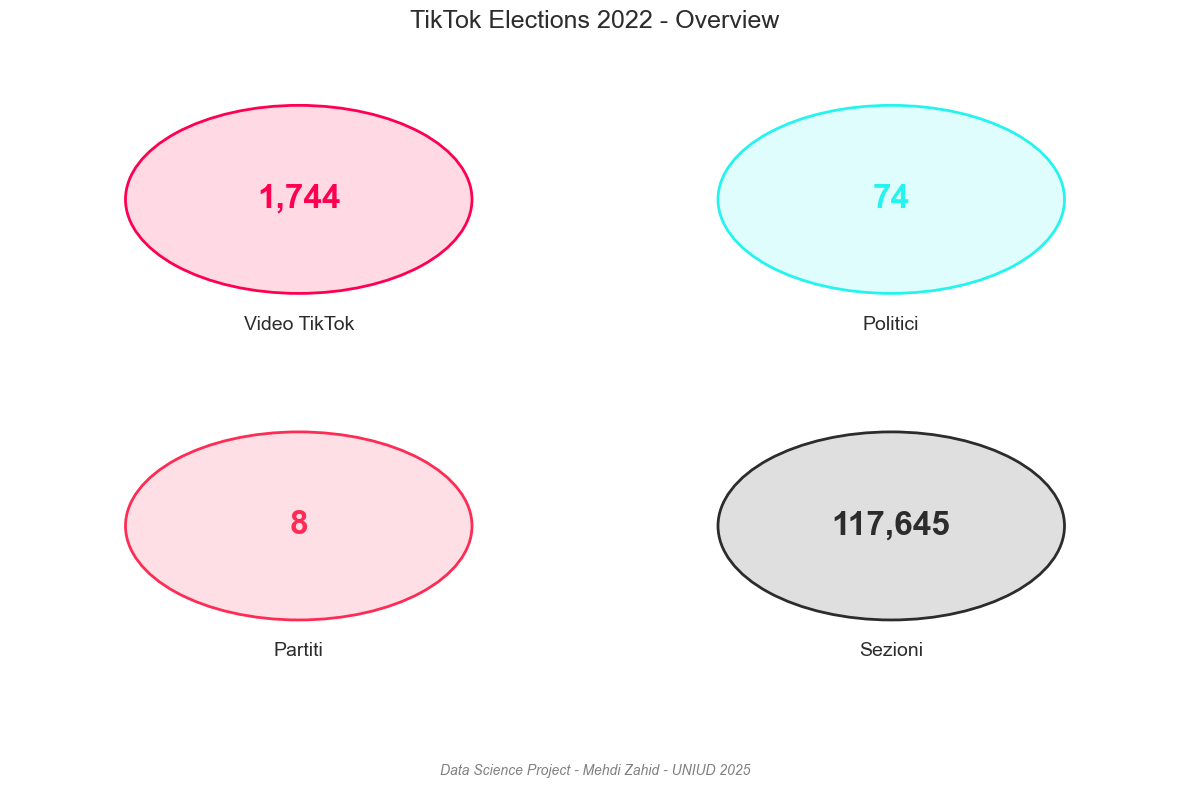

In [182]:
COLORS = {
    'primary': '#FF0050',   
    'secondary': '#25F4EE',  
    'accent': '#FE2C55',     
    'dark': '#2C2C2C',
    'light': '#F8F9FA'
}

# Figura minimal
fig, axes = plt.subplots(2, 2, figsize=(12, 8), facecolor='white')
fig.suptitle('TikTok Elections 2022 - Overview', fontsize=18, fontweight='300', color=COLORS['dark'])

# Dati
data = [
    {'value': 1744, 'label': 'Video TikTok', 'color': COLORS['primary']},
    {'value': 74, 'label': 'Politici', 'color': COLORS['secondary']},
    {'value': 8, 'label': 'Partiti', 'color': COLORS['accent']},
    {'value': 117645, 'label': 'Sezioni', 'color': COLORS['dark']}
]

# Creo grafici minimal
for i, (ax, info) in enumerate(zip(axes.flat, data)):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Cerchio semplice
    circle = plt.Circle((0.5, 0.6), 0.3, color=info['color'], alpha=0.15)
    ax.add_patch(circle)
    
    # Bordo sottile
    circle_border = plt.Circle((0.5, 0.6), 0.3, fill=False, 
                              edgecolor=info['color'], linewidth=2)
    ax.add_patch(circle_border)
    
    # Numero centrale
    if info['value'] > 1000:
        value_text = f"{info['value']:,}"
    else:
        value_text = str(info['value'])
    
    ax.text(0.5, 0.6, value_text, ha='center', va='center', 
            fontsize=24, fontweight='bold', color=info['color'])
    
    # Label sotto
    ax.text(0.5, 0.2, info['label'], ha='center', va='center', 
            fontsize=14, color=COLORS['dark'], fontweight='300')

# Footer minimal
fig.text(0.5, 0.02, 'Data Science Project - Mehdi Zahid - UNIUD 2025',
         ha='center', va='bottom', fontsize=10, color='gray', style='italic')

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.show()

📈 Creazione visualizzazioni complementari con Matplotlib...


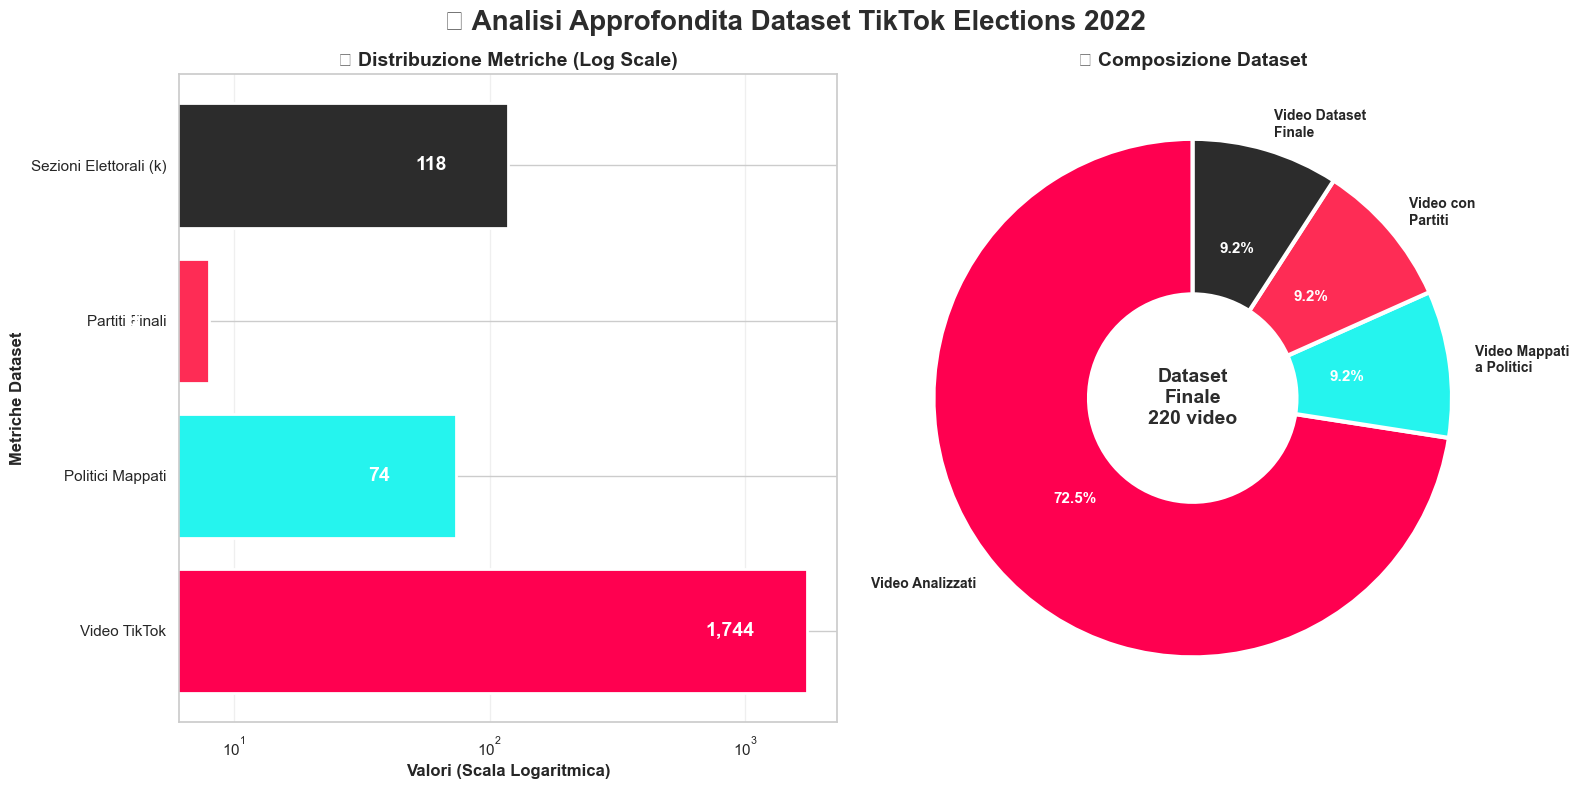

✅ Visualizzazioni complementari completate con Matplotlib!

📊 Statistiche Dataset:
   • Video TikTok totali: 1,744
   • Politici mappati: 74
   • Partiti finali: 8
   • Percentuale video utilizzati: 12.6%


In [183]:
# 📊 VISUALIZZAZIONI COMPLEMENTARI - Bar Chart e Pie Chart (Matplotlib)
print("📈 Creazione visualizzazioni complementari con Matplotlib...")

# Definisco i colori TikTok se non già definiti
TIKTOK_COLORS = {
    'primary': '#FF0050',   
    'secondary': '#25F4EE',  
    'accent': '#FE2C55',     
    'dark': '#2C2C2C'
}

# Creo subplot con bar chart e pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('🔍 Analisi Approfondita Dataset TikTok Elections 2022', 
             fontsize=20, color=TIKTOK_COLORS['dark'], fontweight='bold')

# === GRAFICO 1: BAR CHART ORIZZONTALE CON SCALA LOGARITMICA ===
# Dati per bar chart
metrics = ['Video TikTok', 'Politici Mappati', 'Partiti Finali', 'Sezioni Elettorali (k)']
values = [1744, 74, 8, 117.645]  # Ultima in migliaia per visualizzazione
colors_bar = [TIKTOK_COLORS['primary'], TIKTOK_COLORS['secondary'], 
              TIKTOK_COLORS['accent'], TIKTOK_COLORS['dark']]

# Bar chart orizzontale
bars = ax1.barh(metrics, values, color=colors_bar, edgecolor='white', linewidth=2)

# Configurazione scala logaritmica
ax1.set_xscale('log')
ax1.set_xlabel('Valori (Scala Logaritmica)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Metriche Dataset', fontsize=12, fontweight='bold')
ax1.set_title('📊 Distribuzione Metriche (Log Scale)', fontsize=14, fontweight='bold')

# Aggiungo testi sui bar
for i, (bar, value) in enumerate(zip(bars, values)):
    width = bar.get_width()
    if value > 100:
        text = f'{value:,.0f}'
    else:
        text = f'{value:.0f}'
    
    ax1.text(width/2, bar.get_y() + bar.get_height()/2, text,
             ha='center', va='center', color='white', fontsize=14, 
             fontweight='bold', family='Arial')

# Grid e styling
ax1.grid(True, alpha=0.3, axis='x')
ax1.set_axisbelow(True)

# === GRAFICO 2: DONUT CHART ===
# Dati per pie chart
pie_labels = ['Video Analizzati', 'Video Mappati\na Politici', 'Video con\nPartiti', 'Video Dataset\nFinale']
pie_values = [1744, 220, 220, 220]  # Semplificato per visualizzazione
pie_colors = [TIKTOK_COLORS['primary'], TIKTOK_COLORS['secondary'], 
              TIKTOK_COLORS['accent'], TIKTOK_COLORS['dark']]

# Creo il donut chart
wedges, texts, autotexts = ax2.pie(pie_values, labels=pie_labels, colors=pie_colors,
                                   autopct='%1.1f%%', startangle=90,
                                   wedgeprops=dict(width=0.6, edgecolor='white', linewidth=3),
                                   textprops={'fontsize': 10, 'fontweight': 'bold'})

# Styling del pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# Titolo del pie chart
ax2.set_title('🥧 Composizione Dataset', fontsize=14, fontweight='bold')

# Annotazione centrale del donut
ax2.text(0, 0, f'Dataset\nFinale\n220 video', ha='center', va='center',
         fontsize=14, fontweight='bold', color=TIKTOK_COLORS['dark'],
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# === LAYOUT FINALE ===
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Background bianco
fig.patch.set_facecolor('white')

# Mostra il grafico
plt.show()
print("✅ Visualizzazioni complementari completate con Matplotlib!")

# === STATISTICHE AGGIUNTIVE ===
print("\n📊 Statistiche Dataset:")
print(f"   • Video TikTok totali: {1744:,}")
print(f"   • Politici mappati: {74}")
print(f"   • Partiti finali: {8}")
print(f"   • Percentuale video utilizzati: {220/1744*100:.1f}%")

In [186]:
print("\n🔄 PREPROCESSING DATASET FINALE")
print("=" * 50)

# 1. Filtra dati social con match validi (utilizzando la variabile corretta)
df_social_matched = social_data_mapped[
    (social_data_mapped['MATCHED'] == True) & 
    (social_data_mapped['NOME_POLITICO_REALE'].notna()) & 
    (social_data_mapped['NOME_POLITICO_REALE'] != '')
].copy()

print(f"📱 Video con politici identificati: {len(df_social_matched)}")
print(f"👤 Politici unici trovati: {df_social_matched['NOME_POLITICO_REALE'].nunique()}")

# 2. Carica mapping politici-partiti se non già caricato
try:
    df_mapping_finale = pd.read_csv('src/output-data/mapping_politici_partiti_finale.csv')
    print(f"🔗 Mapping politici-partiti caricato: {len(df_mapping_finale)} politici mappati")
except:
    print("⚠️ File mapping_politici_partiti_finale.csv non trovato, utilizzo PARTITO_REALE dai dati social")
    # Fallback: usa il partito già mappato nei dati social
    df_social_partiti = df_social_matched.copy()
    df_social_partiti['PARTITO_UFFICIALE'] = df_social_partiti['PARTITO_REALE']

# Se il mapping è stato caricato, fai il merge
if 'df_mapping_finale' in locals():
    df_social_partiti = df_social_matched.merge(
        df_mapping_finale[['NOME_POLITICO', 'PARTITO_UFFICIALE']], 
        left_on='NOME_POLITICO_REALE', 
        right_on='NOME_POLITICO', 
        how='left'
    )
    # Fallback per i non mappati: usa PARTITO_REALE
    df_social_partiti['PARTITO_UFFICIALE'] = df_social_partiti['PARTITO_UFFICIALE'].fillna(df_social_partiti['PARTITO_REALE'])

# 3. Filtra solo record con partito ufficiale
df_analysis = df_social_partiti[
    df_social_partiti['PARTITO_UFFICIALE'].notna()
].copy()

print(f"🏛️ Video con partiti mappati: {len(df_analysis)}")
print(f"🗳️ Partiti ufficiali: {df_analysis['PARTITO_UFFICIALE'].nunique()}")

# 4. Aggregazione dati social per partito
print("\n📊 Aggregazione metriche TikTok per partito...")

social_agg = df_analysis.groupby('PARTITO_UFFICIALE').agg({
    'video_id': 'count',                    # Numero post
    'video_playcount': 'sum',               # Totale views
    'video_diggcount': 'sum',               # Totale likes  
    'video_commentcount': 'sum',            # Totale commenti
    'video_sharecount': 'sum',              # Totale shares
    'NOME_POLITICO_REALE': 'nunique'        # Numero politici
}).reset_index()

# 5. Rinomina colonne per chiarezza
social_agg.rename(columns={
    'PARTITO_UFFICIALE': 'PARTITO',
    'video_id': 'NUMERO_POST_TIKTOK',
    'video_playcount': 'TOTALE_VIEWS_TIKTOK',
    'video_diggcount': 'TOTALE_LIKES_TIKTOK',
    'video_commentcount': 'TOTALE_COMMENTI_TIKTOK',
    'video_sharecount': 'TOTALE_SHARES_TIKTOK',
    'NOME_POLITICO_REALE': 'NUMERO_POLITICI'
}, inplace=True)

# 6. Calcola metriche derivate
social_agg['ENGAGEMENT_TOTALE'] = (
    social_agg['TOTALE_LIKES_TIKTOK'] + 
    social_agg['TOTALE_COMMENTI_TIKTOK'] + 
    social_agg['TOTALE_SHARES_TIKTOK']
)

social_agg['ENGAGEMENT_PER_POST'] = (
    social_agg['ENGAGEMENT_TOTALE'] / social_agg['NUMERO_POST_TIKTOK']
).fillna(0)

social_agg['VIEWS_PER_POST'] = (
    social_agg['TOTALE_VIEWS_TIKTOK'] / social_agg['NUMERO_POST_TIKTOK']
).fillna(0)

# 7. Prepara dati elettorali
print("\n🗳️ Aggregazione risultati elettorali...")

election_agg = df_election.groupby('LISTA')['VOTI LISTE'].sum().reset_index()
election_agg.rename(columns={'LISTA': 'PARTITO', 'VOTI LISTE': 'TOTALE_VOTI_LISTA'}, inplace=True)

# 8. Merge finale: dati social + elettorali
print("\n🔗 Creazione dataset finale integrato...")

merged_data = social_agg.merge(election_agg, on='PARTITO', how='inner')

if len(merged_data) == 0:
    print("❌ ERRORE: Nessun partito in comune tra dati social e elettorali!")
    print("\nPartiti social:", social_agg['PARTITO'].tolist())
    print("\nPartiti elettorali (sample):", election_agg['PARTITO'].head(10).tolist())
else:
    # 9. Calcola percentuali e ranking
    total_votes = merged_data['TOTALE_VOTI_LISTA'].sum()
    merged_data['PERCENTUALE_VOTI'] = (merged_data['TOTALE_VOTI_LISTA'] / total_votes) * 100
    merged_data = merged_data.sort_values('TOTALE_VOTI_LISTA', ascending=False).reset_index(drop=True)
    
    print(f"\n✅ DATASET FINALE CREATO:")
    print(f"📊 Partiti analizzati: {len(merged_data)}")
    print(f"🗳️ Voti totali: {merged_data['TOTALE_VOTI_LISTA'].sum():,}")
    print(f"📱 Post TikTok: {merged_data['NUMERO_POST_TIKTOK'].sum()}")
    print(f"👀 Views totali: {merged_data['TOTALE_VIEWS_TIKTOK'].sum():,}")
    print(f"💝 Engagement totale: {merged_data['ENGAGEMENT_TOTALE'].sum():,}")
    
    # 10. Preview dataset
    print(f"\n📋 PREVIEW DATASET FINALE:")
    preview_cols = ['PARTITO', 'TOTALE_VOTI_LISTA', 'PERCENTUALE_VOTI', 'NUMERO_POST_TIKTOK', 'ENGAGEMENT_TOTALE']
    print(merged_data[preview_cols].head().to_string(index=False))


🔄 PREPROCESSING DATASET FINALE
📱 Video con politici identificati: 220
👤 Politici unici trovati: 74
🔗 Mapping politici-partiti caricato: 74 politici mappati
🏛️ Video con partiti mappati: 220
🗳️ Partiti ufficiali: 8

📊 Aggregazione metriche TikTok per partito...

🗳️ Aggregazione risultati elettorali...

🔗 Creazione dataset finale integrato...

✅ DATASET FINALE CREATO:
📊 Partiti analizzati: 8
🗳️ Voti totali: 24,294,601
📱 Post TikTok: 220
👀 Views totali: 333,847,316
💝 Engagement totale: 22,656,879

📋 PREVIEW DATASET FINALE:
                                                PARTITO  TOTALE_VOTI_LISTA  PERCENTUALE_VOTI  NUMERO_POST_TIKTOK  ENGAGEMENT_TOTALE
                   FRATELLI D'ITALIA CON GIORGIA MELONI            7096109         29.208584                  54            5421707
PARTITO DEMOCRATICO - ITALIA DEMOCRATICA E PROGRESSISTA            5126682         21.102145                  51            1735463
                                     MOVIMENTO 5 STELLE            4175676   

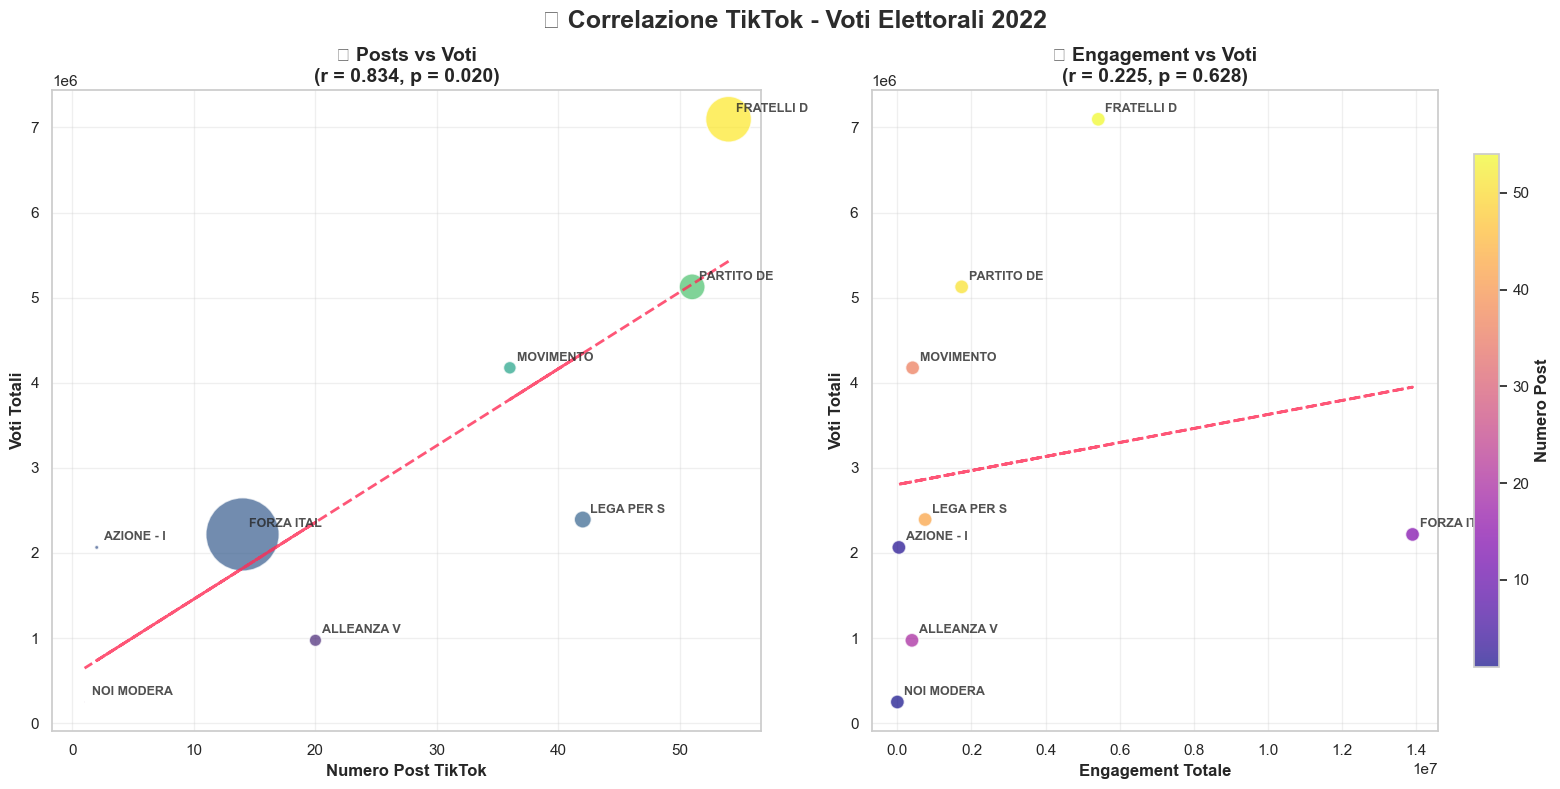

In [185]:
# 📈 SCATTER PLOT: CORRELAZIONE PRINCIPALE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('📊 Correlazione TikTok - Voti Elettorali 2022', 
             fontsize=18, fontweight='bold', color=TIKTOK_COLORS['dark'])

# === GRAFICO 1: POSTS vs VOTI ===
# Scatter plot con dimensioni proporzionali all'engagement
sizes = merged_data['ENGAGEMENT_TOTALE'] / 5000  # Scala per dimensioni
colors = merged_data['TOTALE_VOTI_LISTA']

scatter1 = ax1.scatter(merged_data['NUMERO_POST_TIKTOK'], 
                      merged_data['TOTALE_VOTI_LISTA'],
                      s=sizes, c=colors, 
                      cmap='viridis', alpha=0.7,
                      edgecolors='white', linewidth=1)

# Linea di tendenza
z1 = np.polyfit(merged_data['NUMERO_POST_TIKTOK'], merged_data['TOTALE_VOTI_LISTA'], 1)
p1 = np.poly1d(z1)
ax1.plot(merged_data['NUMERO_POST_TIKTOK'], 
         p1(merged_data['NUMERO_POST_TIKTOK']), 
         "--", color=TIKTOK_COLORS['accent'], alpha=0.8, linewidth=2)

# Annotazioni partiti
for _, row in merged_data.iterrows():
    ax1.annotate(row['PARTITO'][:10], 
                (row['NUMERO_POST_TIKTOK'], row['TOTALE_VOTI_LISTA']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8, fontweight='bold')

ax1.set_xlabel('Numero Post TikTok', fontweight='bold', fontsize=12)
ax1.set_ylabel('Voti Totali', fontweight='bold', fontsize=12)
ax1.set_title(f'📱 Posts vs Voti\n(r = {corr_posts:.3f}, p = {p_posts:.3f})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# === GRAFICO 2: ENGAGEMENT vs VOTI ===
scatter2 = ax2.scatter(merged_data['ENGAGEMENT_TOTALE'], 
                      merged_data['TOTALE_VOTI_LISTA'],
                      s=100, c=merged_data['NUMERO_POST_TIKTOK'], 
                      cmap='plasma', alpha=0.7,
                      edgecolors='white', linewidth=1)

# Linea di tendenza
z2 = np.polyfit(merged_data['ENGAGEMENT_TOTALE'], merged_data['TOTALE_VOTI_LISTA'], 1)
p2 = np.poly1d(z2)
ax2.plot(merged_data['ENGAGEMENT_TOTALE'], 
         p2(merged_data['ENGAGEMENT_TOTALE']), 
         "--", color=TIKTOK_COLORS['accent'], alpha=0.8, linewidth=2)

# Annotazioni partiti
for _, row in merged_data.iterrows():
    ax2.annotate(row['PARTITO'][:10], 
                (row['ENGAGEMENT_TOTALE'], row['TOTALE_VOTI_LISTA']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8, fontweight='bold')

ax2.set_xlabel('Engagement Totale', fontweight='bold', fontsize=12)
ax2.set_ylabel('Voti Totali', fontweight='bold', fontsize=12)
ax2.set_title(f'💝 Engagement vs Voti\n(r = {corr_eng:.3f}, p = {p_eng:.3f})', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter2, ax=ax2, shrink=0.8)
cbar.set_label('Numero Post', fontweight='bold')

plt.tight_layout()
plt.show()